# Question-Answer Validation: Large Language Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/alvaro-francisco-gil/language-technologies-applications/blob/main/exercises/02_classification_by_llm.ipynb) 
[![View on GitHub](https://img.shields.io/badge/Open%20on-GitHub-blue?logo=github)](https://github.com/alvaro-francisco-gil/language-technologies-applications/blob/main/exercises/02_classification_by_llm.ipynb)



The task of this experiment is to measure how much of the truthfulness of a question-answer pair can be inferred using both machine learning and deep learning approaches

## Imports

If you are running this notebook in Google Colab, you can install the required packages by running the following cell:


In [19]:
# !pip install torch pandas numpy seaborn matplotlib #and the rest of the packages

In [20]:
from datasets import load_dataset
import openai
from openai import OpenAI
from pathlib import Path
from typing import List, Dict, Any
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import time

from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
openai.api_key = openai_api_key

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Preparation

In [21]:
boolq = load_dataset("boolq")

print(f"Available splits: {boolq.keys()}")
print(f"Training set size: {boolq['train'].shape}")
print(f"Validation set size: {boolq['validation'].shape}")

print("\nExample data point:")
boolq["train"][0]

Available splits: dict_keys(['train', 'validation'])
Training set size: (9427, 3)
Validation set size: (3270, 3)

Example data point:


{'question': 'do iran and afghanistan speak the same language',
 'answer': True,
 'passage': 'Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.'}

For this task, we chose the dataset boolq, which is a dataset of boolean questions and answers. As our aim is not directly answering the question, but evaluating wether the answer of a question is correct, we first need to transform the dataset into a question-answer format. For this, we divide each datapoint into two, the correct question-answer pair and the incorrect one.

In [22]:
# Create new training and validation datasets with correct and incorrect question-answer pairs
new_train_data = []
new_validation_data = []

# Process training data
for example in boolq["train"]:
    # Create correct pair
    correct_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{example['answer']}'",
        "label": "correct"
    }
    new_train_data.append(correct_pair)
    
    # Create incorrect pair
    incorrect_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{not example['answer']}'",
        "label": "incorrect"
    }
    new_train_data.append(incorrect_pair)

# Process validation data
for example in boolq["validation"]:
    # Create correct pair
    correct_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{example['answer']}'",
        "label": "correct"
    }
    new_validation_data.append(correct_pair)
    
    # Create incorrect pair
    incorrect_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{not example['answer']}'",
        "label": "incorrect"
    }
    new_validation_data.append(incorrect_pair)

print("Training examples:")
print(new_train_data[0])
print(new_train_data[1])
print("\nValidation examples:")
print(new_validation_data[0])
print(new_validation_data[1])

Training examples:
{'text': "The question is 'do iran and afghanistan speak the same language' and the answer is 'True'", 'label': 'correct'}
{'text': "The question is 'do iran and afghanistan speak the same language' and the answer is 'False'", 'label': 'incorrect'}

Validation examples:
{'text': "The question is 'does ethanol take more energy make that produces' and the answer is 'False'", 'label': 'correct'}
{'text': "The question is 'does ethanol take more energy make that produces' and the answer is 'True'", 'label': 'incorrect'}


In [38]:
len(new_validation_data)

6540

By composition, the dataset will be perfectly balanced, with 50% of the data being correct and 50% being incorrect.

Separate x and y

In [24]:
X_train = [example['text'] for example in new_train_data]
y_train = [example['label'] for example in new_train_data]

X_validation = [example['text'] for example in new_validation_data]
y_validation = [example['label'] for example in new_validation_data]

print(X_train[0])
print(y_train[0])


The question is 'do iran and afghanistan speak the same language' and the answer is 'True'
correct


## Answer Capabilities Evaluation

As a benchmark, we first evaluate the performance of an LLM in answering questions directly, which allows us to measure the performance gap between different question framings. While the main goal of this study is to evaluate the truthfulness of question-answer pairs, we begin by assessing the model's ability to answer questions directly.

In [25]:
def evaluate_boolq_llm(
    test_data, 
    model_name="gpt-4", 
    use_passage=False, 
    results_dir="results", 
    timeout=60.0
):
    """
    Evaluate BoolQ by asking the LLM to answer the question, optionally with passage as context.
    Args:
        test_data: List of dicts with 'question', 'answer', and 'passage'
        model_name: LLM model name
        use_passage: If True, include passage in the prompt
        results_dir: Where to save results
        timeout: API timeout
    """
    client = OpenAI(timeout=timeout)
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    results = {
        "model": model_name,
        "task": "answering-boolq",
        "use_passage": use_passage,
        "total_examples": len(test_data),
        "predictions": [],
        "metadata": {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "timeout": timeout
        }
    }
    for i, ex in enumerate(test_data):
        if use_passage:
            prompt = (
                "You are given a passage and a question. Answer the question with 'True' or 'False'.\n\n"
                f"Passage: {ex['passage']}\n"
                f"Question: {ex['question']}\n"
                "Answer:"
            )
        else:
            prompt = (
                "You are given a question. Answer with 'True' or 'False'.\n\n"
                f"Question: {ex['question']}\n"
                "Answer:"
            )
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that answers questions."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            answer = response.choices[0].message.content.strip()
            results["predictions"].append({
                "example_id": i,
                "question": ex["question"],
                "passage": ex["passage"] if use_passage else None,
                "ground_truth": ex["answer"],
                "prediction": answer
            })
            # Save every 10 examples
            if (i + 1) % 10 == 0:
                with open(f"{results_dir}/boolq_eval_{model_name}_{'withpassage' if use_passage else 'nopassage'}.json", "w") as f:
                    json.dump(results, f, indent=2)
        except Exception as e:
            print(f"Error on example {i}: {e}")
            results["predictions"].append({
                "example_id": i,
                "error": str(e)
            })
    # Save final results
    with open(f"{results_dir}/boolq_eval_{model_name}_{'withpassage' if use_passage else 'nopassage'}.json", "w") as f:
        json.dump(results, f, indent=2)
    return results

In [39]:
test_data = [dict(q) for q in boolq["validation"]]
len(test_data)

3270

The dataset is composed also by the passage, which is a text that can be used to answer the question. We try both with and without passage to measure the difference in performance.

In [27]:
# With passage
results_with_passage = evaluate_boolq_llm(
    test_data=test_data,
    model_name="gpt-4o-mini",
    use_passage=True
)

In [28]:
# Without passage
results_no_passage = evaluate_boolq_llm(
    test_data=test_data,
    model_name="gpt-4o-mini",
    use_passage=False
)

## Grading Capabilities Evaluation

Now, we move to the main goal of the experiment, which is to evaluate the truthfulness of a question-answer pair. We do this by asking the LLM to grade the question-answer pair as correct or incorrect.

In [29]:
def evaluate_qa_pair_judgment_llm(
    test_data: List[Dict[str, Any]],
    model_name: str = "gpt-4o-mini",
    use_context: bool = False,  # Not used, but kept for compatibility
    results_dir: str = "results",
    timeout: float = 900.0
) -> Dict[str, Any]:
    """
    Evaluate LLM's ability to judge if a question-answer pair is correct.
    Args:
        test_data: List of dicts with 'text' (e.g., "The question is ... and the answer is ...") and 'label' ("correct"/"incorrect")
        model_name: LLM model name
        use_context: (ignored, for compatibility)
        results_dir: Where to save results
        timeout: API timeout
    """
    client = OpenAI(timeout=timeout)
    Path(results_dir).mkdir(parents=True, exist_ok=True)
    results = {
        "model": model_name,
        "task": "grading-boolq",
        "use_context": use_context,
        "total_examples": len(test_data),
        "predictions": [],
        "metadata": {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "timeout": timeout
        }
    }
    for i, ex in enumerate(test_data):
        prompt = (
            "You are given a question and an answer. "
            "Evaluate if the answer is correct for the question. "
            "Respond with {\"answer\": \"correct\"} or {\"answer\": \"incorrect\"}.\n\n"
            f"{ex['text']}\n"
        )
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that evaluates if answers to questions are correct."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            prediction = response.choices[0].message.content.strip()
            results["predictions"].append({
                "example_id": i,
                "text": ex["text"],
                "ground_truth": ex["label"],
                "prediction": prediction
            })
            # Save every 10 examples
            if (i + 1) % 10 == 0:
                with open(f"{results_dir}/grading_boolq_{model_name}.json", "w") as f:
                    json.dump(results, f, indent=2)
        except Exception as e:
            print(f"Error on example {i}: {e}")
            results["predictions"].append({
                "example_id": i,
                "error": str(e)
            })
    # Save final results
    context_suffix = "_with_context" if use_context else "_no_context"
    with open(f"{results_dir}/grading_boolq_{model_name}{context_suffix}.json", "w") as f:
        json.dump(results, f, indent=2)
    return results

In [30]:
test_data = [
    {"text": x, "label": y}
    for x, y in zip(X_validation, y_validation)
]

test_data[0]

{'text': "The question is 'does ethanol take more energy make that produces' and the answer is 'False'",
 'label': 'correct'}

In [31]:
results = evaluate_qa_pair_judgment_llm(
    test_data=test_data,
    model_name="gpt-4o-mini",
    use_context=False
)

In [32]:
results = evaluate_qa_pair_judgment_llm(
    test_data=test_data,
    model_name="gpt-4o-mini",
    use_context=True
)

## Results

In [36]:
result_files = glob.glob("results/*.json")
all_results = []

for file in result_files:
    with open(file, "r") as f:
        results = json.load(f)
        task = results.get("task")
        if not task:
            # Heuristic: if predictions are True/False, it's answering-boolq
            first_pred = results["predictions"][0].get("prediction", "")
            if isinstance(first_pred, str) and (first_pred.strip().lower() in ["true", "false", "'true'", "'false'", '"true"', '"false"']):
                task = "answering-boolq"
            else:
                task = "grading-boolq"
        use_passage = results.get("use_passage", results.get("use_context"))
        if use_passage is None:
            # Try to infer from filename
            if "nopassage" in file:
                use_passage = False
            elif "withpassage" in file:
                use_passage = True
            else:
                # Fallback: check if 'passage' is present in any prediction
                # For grading-boolq, the 'text' field may contain the passage
                # Heuristic: if the word "passage" appears in the text, assume use_passage=True
                first_pred = results["predictions"][0]
                if "text" in first_pred and "passage" in first_pred["text"].lower():
                    use_passage = True
                else:
                    use_passage = False
        for pred in results["predictions"]:
            pred["model"] = results.get("model")
            pred["task"] = task
            pred["use_passage"] = use_passage
        all_results.extend(results["predictions"])

df = pd.DataFrame(all_results)
df.shape

(26160, 9)

In [34]:
# For answering-boolq (model answers True/False)
def normalize_answer(ans):
    if isinstance(ans, str):
        ans = ans.strip().lower()
        if ans in ["true", "'true'", '"true"']:
            return True
        if ans in ["false", "'false'", '"false"']:
            return False
    if isinstance(ans, bool):
        return ans
    return None

# For grading-boolq (model outputs {"answer": "correct"} or {"answer": "incorrect"})
def extract_grading_label(pred):
    if isinstance(pred, str):
        m = re.search(r'"answer"\s*:\s*"?(correct|incorrect)"?', pred, re.IGNORECASE)
        if m:
            return m.group(1).lower()
    return None

# Prepare DataFrames for each task
df_answering = df[df["task"] == "answering-boolq"].copy()
df_answering["prediction_norm"] = df_answering["prediction"].apply(normalize_answer)
df_answering["ground_truth_norm"] = df_answering["ground_truth"].apply(
    lambda x: x if isinstance(x, bool) else (x.lower() == "true")
)

df_grading = df[df["task"] == "grading-boolq"].copy()
df_grading["prediction_norm"] = df_grading["prediction"].apply(extract_grading_label)
df_grading["ground_truth_norm"] = df_grading["ground_truth"].str.lower()

summary = []
for task, d in [("answering-boolq", df_answering), ("grading-boolq", df_grading)]:
    for context, group in d.groupby("use_passage"):
        acc = (group["prediction_norm"] == group["ground_truth_norm"]).mean() * 100
        summary.append({"task": task, "use_passage": context, "accuracy": acc})
summary_df = pd.DataFrame(summary)
display(summary_df)

,task,use_passage,accuracy
0,answering-boolq,False,75.840979
1,answering-boolq,True,87.859327
2,grading-boolq,False,70.550459
3,grading-boolq,True,70.611621


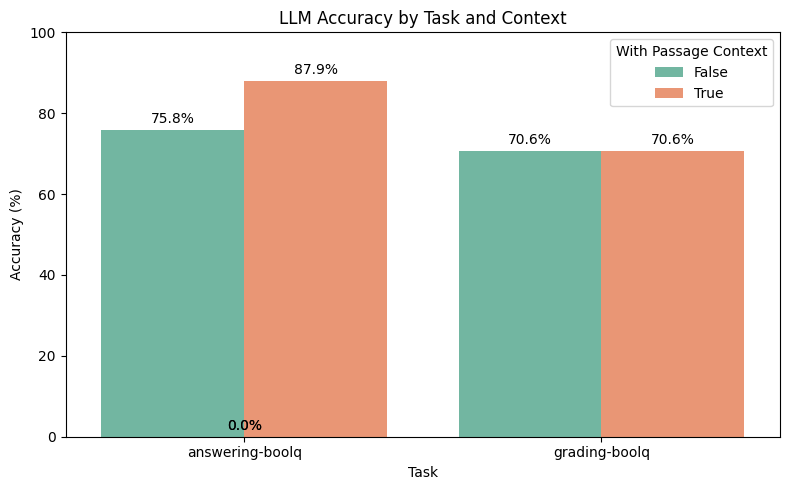

In [35]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=summary_df,
    x="task",
    y="accuracy",
    hue="use_passage",
    palette="Set2"
)
plt.title("LLM Accuracy by Task and Context")
plt.ylabel("Accuracy (%)")
plt.xlabel("Task")
plt.legend(title="With Passage Context")
plt.ylim(0, 100)

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha="center", va="bottom")

plt.tight_layout()
plt.show()

The results reveal interesting patterns in the LLM's performance. While the model demonstrates reasonable accuracy in both tasks, its performance notably decreases when questions are framed as grading tasks. This observation aligns with the "framing effect," a well-documented psychological phenomenon that appears to extend to language models as well.

Regarding context usage, we observe a significant performance improvement when the passage context is provided for direct question answering. This enhancement is expected, as the additional context provides more information for the model to work with. However, this benefit does not extend to the grading task, where context appears to have minimal impact on performance. This suggests that the LLM's reasoning capabilities are more dependent on the task structure and framing rather than the availability of contextual information, highlighting the importance of task design in LLM applications.

-------------------------------------------


Thanks for reading the code, connect with me on [LinkedIn](https://www.linkedin.com/in/alvaro-francisco-gil/) or [GitHub](https://github.com/alvaro-francisco-gil) if you have any questions or comments.

*Álvaro Francisco Gil*